In [1]:
pip install dateparser

Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
from pathlib import Path
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import dateparser
from sklearn import preprocessing
from datetime import datetime

In [3]:
city_district = ['Altstadt-Lehel', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Schwabing-West'
    , 'Au-Haidhausen', 'Sendling', 'Sendling-Westpark', 'Schwanthalerhöhe'
    , 'Neuhausen-Nymphenburg', 'München-Moosach', 'Milbertshofen-Am Hart', 'Schwabing-Freimann'
    , 'Bogenhausen', 'Berg am Laim', 'Trudering-Riem', 'Ramersdorf-Perlach', 'Obergiesing'
    , 'Untergiesing-Harlaching', 'Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln', 'Hadern'
    , 'Pasing-Obermenzing', 'Aubing-Lochhausen-Langwied', 'Allach-Untermenzing', 'Feldmoching-Hasenbergl'
    , 'Laim']

outdoors_places = ['Allianz Arena', 'Englischer Garten','Eisbachwelle', 'Viktualienmarkt', 'Westpark']

indoors_places = ['Frauenkirche','Olympiaturm', 'Schloss Nymphenburg','Städtische Galerie im Lenbachhaus']


In [4]:
import dateparser

path = "../data/Tripadvisor_datasets/Tripadvisor_Datasets/*.csv"
dataframe = pd.DataFrame()
for fname in glob.glob(path):
    x = pd.read_csv(fname, low_memory=False)
    #print(x)
    x = x.dropna(subset=['date'])
    x['date'] = [date.replace('Erlebnisdatum: ', '') for date in x['date']]
    x['place'] = Path(fname).stem
    x['visit'].fillna('', inplace=True)
    x['visit'] = [visit_type.replace('Reiseart: ', '') for visit_type in x['visit']]
    x = x[['date', 'place', 'rating','visitor_origin', 'visit']]
    dataframe = pd.concat([dataframe, x], axis=0)

dataframe.reset_index(drop=True,inplace=True)   
dataframe

,date,place,rating,visitor_origin,visit
0,Juli 2020,Allianz Arena,50,"Salem, Deutschland",
1,Juli 2020,Allianz Arena,10,"Siegen, Deutschland",
2,Juni 2020,Allianz Arena,50,NaN,
3,August 2019,Allianz Arena,40,"Mutters, Österreich",
4,April 2019,Allianz Arena,10,"München, Deutschland",
...,...,...,...,...,...
1582,Dezember 2014,Westpark,50,"Odessa, Ukraine",als Paar
1583,Oktober 2014,Westpark,50,"Hadera, Israel",mit der Familie
1584,August 2014,Westpark,40,"Singapur, Singapur",
1585,Oktober 2013,Westpark,50,"Dublin, Irland",


In [5]:
dataframe['user_id'] = range(1, len(dataframe) + 1)

dataframe = dataframe.reindex(columns=['user_id', 'date', 'place','city_district', 'rating', 'visitor_origin', 'visit','type_door'])
dataframe.reset_index(drop=True,inplace=True)

dataframe.loc[dataframe['place'].isin(outdoors_places),'type_door'] = 'outdoor'
dataframe.loc[dataframe['place'].isin(indoors_places),'type_door'] = 'indoor'

for index, row in dataframe.iterrows():
    dataframe['date'][index] = dataframe['date'][index][:-5]

#sum([True for idx, row in dataframe.iterrows()])
#dataframe.shape[0] - dataframe.dropna().shape[0]
#dataframe.date.dt.days()
#datetime.datetime.dataframe['date'].weekday()

dataframe

C:\Users\ferja\miniconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,user_id,date,place,city_district,rating,visitor_origin,visit,type_door
0,1,Juli,Allianz Arena,NaN,50,"Salem, Deutschland",,outdoor
1,2,Juli,Allianz Arena,NaN,10,"Siegen, Deutschland",,outdoor
2,3,Juni,Allianz Arena,NaN,50,NaN,,outdoor
3,4,August,Allianz Arena,NaN,40,"Mutters, Österreich",,outdoor
4,5,April,Allianz Arena,NaN,10,"München, Deutschland",,outdoor
...,...,...,...,...,...,...,...,...
1582,1583,Dezember,Westpark,NaN,50,"Odessa, Ukraine",als Paar,outdoor
1583,1584,Oktober,Westpark,NaN,50,"Hadera, Israel",mit der Familie,outdoor
1584,1585,August,Westpark,NaN,40,"Singapur, Singapur",,outdoor
1585,1586,Oktober,Westpark,NaN,50,"Dublin, Irland",,outdoor


In [6]:
places = dataframe['place'].unique()

y = {}
geolocator = Nominatim(user_agent='salut', timeout=3)

for place in places:
    try:
        
        if place == 'Frauenkirche':
            place = 'Frauenkirche München'
        location = geolocator.geocode(place, addressdetails=True, country_codes='de')
        location2 = location.address
        if place == 'Frauenkirche München':
            place = 'Frauenkirche'
        for district in city_district:            
            if district in location2:                
                y[place] = district
                
        y['Städtische Galerie im Lenbachhaus'] = 'Altstadt-Lehel'
    except:
        y[place] = ''
        
y

{'Allianz Arena': 'Schwabing-Freimann',
 'Städtische Galerie im Lenbachhaus': 'Altstadt-Lehel',
 'Eisbachwelle': 'Altstadt-Lehel',
 'Englischer Garten': 'Schwabing-Freimann',
 'Frauenkirche': 'Altstadt-Lehel',
 'Olympiaturm': 'Milbertshofen-Am Hart',
 'Schloss Nymphenburg': 'Neuhausen-Nymphenburg',
 'Viktualienmarkt': 'Altstadt-Lehel',
 'Westpark': 'Sendling-Westpark'}

In [7]:
for index, row in dataframe.iterrows():
    dataframe['city_district'][index] = y[row['place']]

C:\Users\ferja\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ferja\miniconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
dataframe

,user_id,date,place,city_district,rating,visitor_origin,visit,type_door
0,1,Juli,Allianz Arena,Schwabing-Freimann,50,"Salem, Deutschland",,outdoor
1,2,Juli,Allianz Arena,Schwabing-Freimann,10,"Siegen, Deutschland",,outdoor
2,3,Juni,Allianz Arena,Schwabing-Freimann,50,NaN,,outdoor
3,4,August,Allianz Arena,Schwabing-Freimann,40,"Mutters, Österreich",,outdoor
4,5,April,Allianz Arena,Schwabing-Freimann,10,"München, Deutschland",,outdoor
...,...,...,...,...,...,...,...,...
1582,1583,Dezember,Westpark,Sendling-Westpark,50,"Odessa, Ukraine",als Paar,outdoor
1583,1584,Oktober,Westpark,Sendling-Westpark,50,"Hadera, Israel",mit der Familie,outdoor
1584,1585,August,Westpark,Sendling-Westpark,40,"Singapur, Singapur",,outdoor
1585,1586,Oktober,Westpark,Sendling-Westpark,50,"Dublin, Irland",,outdoor


In [9]:
dataframe = dataframe.dropna()
dataframe.reset_index(drop=True,inplace=True)
dataframe

,user_id,date,place,city_district,rating,visitor_origin,visit,type_door
0,1,Juli,Allianz Arena,Schwabing-Freimann,50,"Salem, Deutschland",,outdoor
1,2,Juli,Allianz Arena,Schwabing-Freimann,10,"Siegen, Deutschland",,outdoor
2,4,August,Allianz Arena,Schwabing-Freimann,40,"Mutters, Österreich",,outdoor
3,5,April,Allianz Arena,Schwabing-Freimann,10,"München, Deutschland",,outdoor
4,6,Juli,Allianz Arena,Schwabing-Freimann,50,"Salem, Deutschland",mit der Familie,outdoor
...,...,...,...,...,...,...,...,...
1332,1583,Dezember,Westpark,Sendling-Westpark,50,"Odessa, Ukraine",als Paar,outdoor
1333,1584,Oktober,Westpark,Sendling-Westpark,50,"Hadera, Israel",mit der Familie,outdoor
1334,1585,August,Westpark,Sendling-Westpark,40,"Singapur, Singapur",,outdoor
1335,1586,Oktober,Westpark,Sendling-Westpark,50,"Dublin, Irland",,outdoor


In [10]:
# Convert visitor origin labels to numbers
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(dataframe['visitor_origin'])
le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(le_name_mapping)

{'80802 München, Marschallstr. 8': 0, 'Aachen, Deutschland': 1, 'Aarburg, Schweiz': 2, 'Achterwehr, Deutschland': 3, 'Adliswil, Schweiz': 4, 'Allershausen, Deutschland': 5, 'Alsheim, Deutschland': 6, 'Altdorf, Deutschland': 7, 'Altenstadt, Deutschland': 8, 'Alzenau, Deutschland': 9, 'Amriswil, Schweiz': 10, 'Andernach, Deutschland': 11, 'Anterivo, Italien': 12, 'Appenzell, Schweiz': 13, 'Arlesheim, Schweiz': 14, 'Arnis, Deutschland': 15, 'Arona, Italien': 16, 'Aschaffenburg, Deutschland': 17, 'Aspen, Colorado': 18, 'Athen, Griechenland': 19, 'Au, Österreich': 20, 'Augsburg': 21, 'Augsburg, Deutschland': 22, 'Austin, Texas': 23, 'BaWü': 24, 'Backnang, Deutschland': 25, 'Bad Abbach, Deutschland': 26, 'Bad Aibling, Deutschland': 27, 'Bad Bleiberg, Österreich': 28, 'Bad Breisig': 29, 'Bad Dürkheim, Deutschland': 30, 'Bad Homburg, Deutschland': 31, 'Bad Segeberg, Deutschland': 32, 'Bad Wimpfen, Deutschland': 33, 'Baden-Baden, Deutschland': 34, 'Baden-Württemberg, Deutschland': 35, 'Bangalor

In [11]:
# Convert these text labels to numbers
mapping_visit_type = {'mit der Familie': 1, 'mit Freunden': 2, 'als Paar' : 3, 'geschäftlich' : 4, 'allein' : 5, '' : 6 }

mapping_type_door = {'outdoor': 1, 'indoor': 2}
mapping_date = {'Januar': 1, 'Februar': 2,'März': 3,'April': 4,'Mai': 5,'Juni': 6,'Juli': 7, 'August': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Dezember': 12}
mapping_place = {'Allianz Arena': 1, 'Eisbachwelle': 2,'Englischer Garten': 3,'Frauenkirche': 4,'Olympiaturm': 5,'Schloss Nymphenburg': 6,'Städtische Galerie im Lenbachhaus': 7, 'Viktualienmarkt' : 8,'Westpark' : 9}
mapping_city_district = {'Schwabing-Freimann': 1, 'Altstadt-Lehel': 2, 'Milbertshofen-Am Hart': 3, 'Neuhausen-Nymphenburg': 4, 'Sendling-Westpark': 5}
dataframe = dataframe.replace({'visitor_origin':le_name_mapping, 'place': mapping_place, 'type_door' : mapping_type_door, 'date': mapping_date, 'city_district' : mapping_city_district, 'visit' : mapping_visit_type})

dataframe

,user_id,date,place,city_district,rating,visitor_origin,visit,type_door
0,1,7,1,1,50,400,6,1
1,2,7,1,1,10,423,6,1
2,4,8,1,1,40,312,6,1
3,5,4,1,1,10,317,6,1
4,6,7,1,1,50,400,1,1
...,...,...,...,...,...,...,...,...
1332,1583,12,9,5,50,352,3,1
1333,1584,10,9,5,50,170,1,1
1334,1585,8,9,5,40,426,6,1
1335,1586,10,9,5,50,104,6,1


In [12]:
# creating a correlation matrix
df_corr = dataframe.corr().round(2)


# printing correlations
print(df_corr.loc['place'].sort_values(ascending = False))

place             1.00
user_id           0.99
city_district     0.65
type_door         0.24
visit             0.07
date              0.04
rating            0.01
visitor_origin    0.00
Name: place, dtype: float64


In [14]:
import statsmodels.formula.api as smf # regression modeling
# blueprinting a model type
lm_full = smf.ols(formula = """dataframe['place'] ~
                                                dataframe['date'] +
                                                dataframe['rating'] +
                                                dataframe['city_district'] +
                                                dataframe['visitor_origin'] +
                                                dataframe['visit'] +
                                                dataframe['type_door']
                                                """,
                                                data = dataframe)


# Run the data analysis through the blueprint
results_full = lm_full.fit()


# printing the results
results_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     dataframe['place']   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     164.1
Date:                Fri, 28 Aug 2020   Prob (F-statistic):          4.04e-156
Time:                        18:00:00   Log-Likelihood:                -2675.8
No. Observations:                1337   AIC:                             5366.
Df Residuals:                    1330   BIC:                             5402.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.4611      0.397      3.683      0.000       0.683       2.239
dataframe['date']              -0.0054      0.016     -0.339      0.734      -0.037       0.026
dataframe['rating']             0.0081      0.007      1.173      0.241      -0.005       0.022
dataframe['city_district']      1.2498      0.044     28.721      0.000       1.164       1.335
dataframe['visitor_origin']    -0.0004      0.000     -1.120      0.263      -0.001       0.000
dataframe['visit']              0.0640      0.028      2.278      0.023       0.009       0.119
dataframe['type_door']          0.0212      0.107      0.198      0.843      -0.188       0.230
==============================================================================
Omnibus:                      108.317   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.150
Skew:                           0.701   Prob(JB):                     8.12e-27
Kurtosis:                       2.561   Cond. No.                     2.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
!pip install seaborn

<AxesSubplot:xlabel='visit', ylabel='place'>

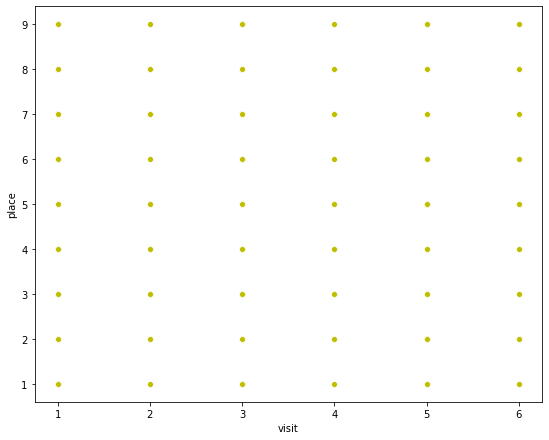

In [19]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (20, 16))
plt.subplot(2, 2, 1)
sns.scatterplot(x = dataframe['visit'],
                y = dataframe['place'],
                color = 'y')

In [20]:
type(dataframe)

pandas.core.frame.DataFrame

In [52]:
# Shift and rescale values so that they end up ranging from 0 to 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(dataframe)

MinMaxScaler()

In [33]:
dataframe_sc = scaler.transform(dataframe)
dataframe_sc.shape

(1337, 8)

In [34]:
dataframe_sc

array([[0.00000000e+00, 5.45454545e-01, 0.00000000e+00, ...,
        7.78210117e-01, 1.00000000e+00, 0.00000000e+00],
       [6.30517024e-04, 5.45454545e-01, 0.00000000e+00, ...,
        8.22957198e-01, 1.00000000e+00, 0.00000000e+00],
       [1.89155107e-03, 6.36363636e-01, 0.00000000e+00, ...,
        6.07003891e-01, 1.00000000e+00, 0.00000000e+00],
       ...,
       [9.98738966e-01, 6.36363636e-01, 1.00000000e+00, ...,
        8.28793774e-01, 1.00000000e+00, 0.00000000e+00],
       [9.99369483e-01, 8.18181818e-01, 1.00000000e+00, ...,
        2.02334630e-01, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.72727273e-01, 1.00000000e+00, ...,
        4.47470817e-02, 2.00000000e-01, 0.00000000e+00]])

In [38]:
dataframe_scaled = pd.DataFrame({'user_id': dataframe_sc[:, 0], 'date': dataframe_sc[:, 1], 'place': dataframe_sc[:, 2], 'city_district': dataframe_sc[:, 3], 'rating': dataframe_sc[:, 4], 'visitor_origin': dataframe_sc[:, 5], 'visit': dataframe_sc[:, 6], 'type_door': dataframe_sc[:, 7]})

In [53]:
dataframe_scaled

,user_id,date,place,city_district,rating,visitor_origin,visit,type_door
0,0.000000,0.545455,0.0,0.0,1.00,0.778210,1.0,0.0
1,0.000631,0.545455,0.0,0.0,0.00,0.822957,1.0,0.0
2,0.001892,0.636364,0.0,0.0,0.75,0.607004,1.0,0.0
3,0.002522,0.272727,0.0,0.0,0.00,0.616732,1.0,0.0
4,0.003153,0.545455,0.0,0.0,1.00,0.778210,0.0,0.0
...,...,...,...,...,...,...,...,...
1332,0.997478,1.000000,1.0,1.0,1.00,0.684825,0.4,0.0
1333,0.998108,0.818182,1.0,1.0,1.00,0.330739,0.0,0.0
1334,0.998739,0.636364,1.0,1.0,0.75,0.828794,1.0,0.0
1335,0.999369,0.818182,1.0,1.0,1.00,0.202335,1.0,0.0


In [41]:
# Split data into training/testing set
from sklearn.model_selection import train_test_split

# train_set, test_set = train_test_split(dataframe, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(dataframe_scaled.drop('place', axis=1), dataframe_scaled['place'], test_size=0.25, random_state=42)

In [42]:
X_train.shape

(1002, 7)

In [43]:
X_test.shape

(335, 7)

In [44]:
y_test.shape

(335,)

In [45]:
y_train.shape

(1002,)

In [46]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=2000,
                          learning_rate=1,
                          depth=2)
model.fit(X_train, y_train)

0:	learn: 0.1312172	total: 52.6ms	remaining: 1m 45s
1:	learn: 0.1003374	total: 53.7ms	remaining: 53.7s
2:	learn: 0.0632780	total: 54.9ms	remaining: 36.5s
3:	learn: 0.0511649	total: 55.7ms	remaining: 27.8s
4:	learn: 0.0418167	total: 56.6ms	remaining: 22.6s
5:	learn: 0.0395281	total: 57.5ms	remaining: 19.1s
6:	learn: 0.0380649	total: 58.3ms	remaining: 16.6s
7:	learn: 0.0322636	total: 59.1ms	remaining: 14.7s
8:	learn: 0.0314467	total: 59.9ms	remaining: 13.3s
9:	learn: 0.0220628	total: 60.7ms	remaining: 12.1s
10:	learn: 0.0206863	total: 61.5ms	remaining: 11.1s
11:	learn: 0.0193922	total: 62.3ms	remaining: 10.3s
12:	learn: 0.0190050	total: 63.1ms	remaining: 9.64s
13:	learn: 0.0183741	total: 63.9ms	remaining: 9.07s
14:	learn: 0.0179726	total: 64.8ms	remaining: 8.57s
15:	learn: 0.0177550	total: 65.6ms	remaining: 8.14s
16:	learn: 0.0164195	total: 66.5ms	remaining: 7.75s
17:	learn: 0.0160085	total: 67.3ms	remaining: 7.41s
18:	learn: 0.0151293	total: 68.2ms	remaining: 7.11s
19:	learn: 0.0132885	

In [58]:
# Make predictions
preds = model.predict(dataframe.drop('place', axis=1)[:50])
preds

array([0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284,
       0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284,
       0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284,
       0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284,
       0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284,
       0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284,
       0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284,
       0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284,
       0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284,
       0.89641284, 0.89641284, 0.89641284, 0.89641284, 0.89641284])